In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string


In [5]:
df = pd.read_csv("train.csv")

In [7]:
df.shape
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [9]:
df.isnull().sum()


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
#target label
LABEL_COLS = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
]

df[LABEL_COLS].sum().sort_values(ascending=False)


toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

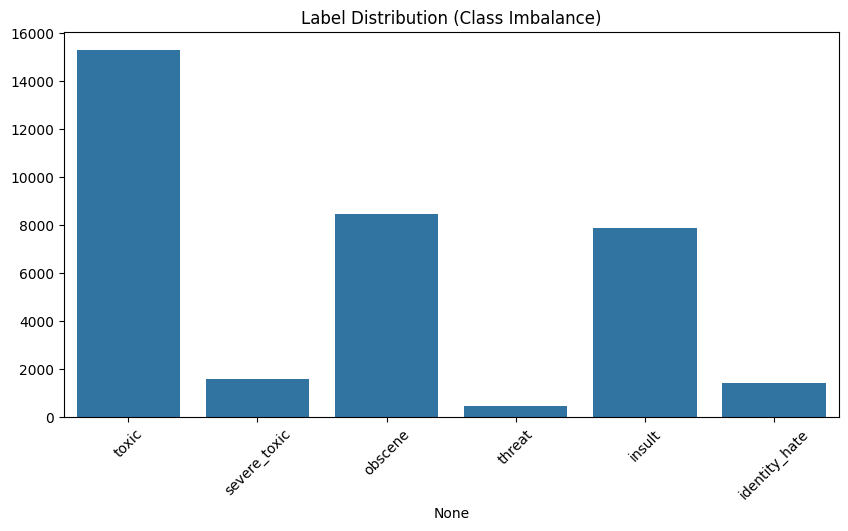

In [ ]:
#Label Distribution Visualization
plt.figure(figsize=(10,5))
sns.barplot(
    x=df[LABEL_COLS].sum().index,
    y=df[LABEL_COLS].sum().values
)
plt.title("Label Distribution (Class Imbalance)")
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Text Length Analysis
df["text_length"] = df["comment_text"].apply(lambda x: len(str(x).split()))

df["text_length"].describe()


count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: text_length, dtype: float64

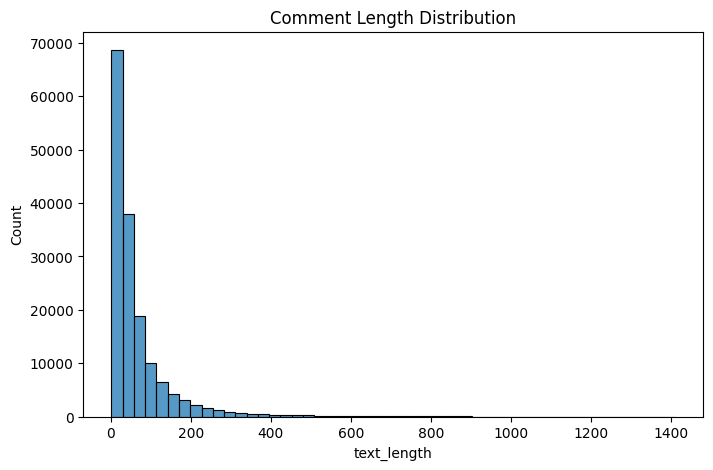

In [ ]:
#Visualize distribution
plt.figure(figsize=(8,5))
sns.histplot(df["text_length"], bins=50)
plt.title("Comment Length Distribution")
plt.show()


In [ ]:
#Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)        # remove URLs
    text = re.sub(r"<.*?>", "", text)                 # remove HTML
    text = re.sub(r"\d+", "", text)                   # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [15]:
df["clean_text"] = df["comment_text"].astype(str).apply(clean_text)


In [ ]:
#Check Empty
(df["clean_text"].str.len() == 0).sum()


np.int64(25)

In [17]:
df = df[df["clean_text"].str.len() > 0]
df.reset_index(drop=True, inplace=True)


In [ ]:
#Multi-Label Target Matrix
X = df["clean_text"]
y = df[LABEL_COLS].values

print(X.shape, y.shape)


(159546,) (159546, 6)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [22]:
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch


In [ ]:
#for vocabulary
def build_vocab(texts, max_vocab_size=50000, min_freq=2):
    counter = Counter()
    for text in texts:
        counter.update(text.split())

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.most_common(max_vocab_size):
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab


In [24]:
vocab = build_vocab(X_train)
vocab_size = len(vocab)
print("Vocab size:", vocab_size)


Vocab size: 50002


In [ ]:
#Encoding text to integer sequence
def encode_text(text, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in text.split()]


In [26]:
X_train_enc = [encode_text(text, vocab) for text in X_train]
X_val_enc   = [encode_text(text, vocab) for text in X_val]


In [28]:
from torch.utils.data import Dataset, DataLoader

class ToxicDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), self.labels[idx]


In [ ]:
#Collate function
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.stack(labels)


In [30]:
train_dataset = ToxicDataset(X_train_enc, y_train)
val_dataset   = ToxicDataset(X_val_enc, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [32]:
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_labels=6):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)

        # Concatenate forward & backward hidden states
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        x = self.dropout(hidden)
        return self.fc(x)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [35]:
model = BiLSTM(vocab_size).to(device)

criterion = nn.BCEWithLogitsLoss()  # CORRECT for multi-label
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [37]:
from sklearn.metrics import f1_score

def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)



In [38]:
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds, targets = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item()
            preds.append(torch.sigmoid(logits).cpu())
            targets.append(y.cpu())

    preds = torch.cat(preds).numpy() > 0.5
    targets = torch.cat(targets).numpy()

    f1 = f1_score(targets, preds, average="micro")
    return total_loss / len(loader), f1


In [39]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_f1 = eval_epoch(model, val_loader)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val F1:     {val_f1:.4f}")
    print("-" * 40)


Epoch 1
Train Loss: 0.0877
Val Loss:   0.0554
Val F1:     0.7086
----------------------------------------
Epoch 2
Train Loss: 0.0514
Val Loss:   0.0490
Val F1:     0.7329
----------------------------------------
Epoch 3
Train Loss: 0.0434
Val Loss:   0.0476
Val F1:     0.7495
----------------------------------------
Epoch 4
Train Loss: 0.0380
Val Loss:   0.0472
Val F1:     0.7461
----------------------------------------
Epoch 5
Train Loss: 0.0334
Val Loss:   0.0489
Val F1:     0.7546
----------------------------------------


In [41]:
import os

os.makedirs("artifacts", exist_ok=True)


In [42]:
torch.save({
    "model_state": model.state_dict(),
    "vocab": vocab
}, "artifacts/lstm_baseline.pt")
